# Text Mining and Sentiment Analysis Project
## "How do you feel, my dear (P8)"
Natalia Kartasheva: 943350

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import re
import string
import nltk

from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

from lightgbm import LGBMClassifier

nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
pd.set_option('display.max_rows',500)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\karta\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Training data (Wassa-2017)

In [2]:
df_anger = pd.read_csv("anger_train.txt", delimiter = "\t", header = None)
df_fear = pd.read_csv("fear_train.txt", delimiter = "\t", header = None)
df_joy = pd.read_csv("joy_train.txt", delimiter = "\t", header = None)
df_sadness = pd.read_csv("sadness_train.txt", delimiter = "\t", header = None)

In [3]:
dfs = [df_anger, df_fear, df_joy, df_sadness]

Renaming columns

In [4]:
for df in dfs:
    df.columns = ["code", "tweet", "sentiment", "intensity"]

Remove some noise: exclude from the analysis the intermediate level of emotions.

In [5]:
for df in dfs:
    df = df[~df['intensity'].between(0.35, 0.65)]

Cleaning tweets

In [6]:
#Create a function to categorize the intensity of the emotion
def categorize(df, column = "intensity", threshold = 0.55):
    df.loc[df[column]  <= threshold, column] = 0
    df.loc[df[column] > threshold, column] = 1
    
# remove non-english words:
def english_words(text):
    words = set(nltk.corpus.words.words())
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    
#Create a function to clean the tweets
def cleanTweets(text):
    text = re.sub(r'(@[A-Za-z0-9?_?]+)','', text) #removes @mentions
    text = re.sub(r'#','',text) #removes "#""
    text = re.sub(r'RT[\s]+', '', text) #removes retweet
    text = re.sub(r'http?:\/\/\S+' , '', text) #removes hyperlink
    text = re.sub('[^\w\s]',' ', text) #Remove punctuation
    text = re.sub('\s+', ' ', text) #Remove double spaces
    text = re.sub(r'\d+','', text) #Remove number
        
    return text

#Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [TreebankWordDetokenizer().detokenize(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))]

# Python program to convert a list to string
def listToString(s): 
    str1 = ""   # initialize an empty string
    for ele in s: 
        str1 += ele  # traverse in the string 
    return str1 

In [7]:
stop_words = stopwords.words("english")
stop_words.extend(['im', 'ima'])

In [8]:
#For each of the four dataset apply the preprocessing
for df in tqdm(dfs):
    categorize(df)
    df["tweet_cleaned"] = df["tweet"].apply(english_words)
    df["tweet_cleaned"] = df["tweet"].apply(cleanTweets)
    df["tweet_cleaned"] = df["tweet_cleaned"].str.lower()
    df["tweet_cleaned"] = df["tweet_cleaned"].apply(lambda x: ' '.join([item for item in x.split() \
                                                                        if item not in stop_words]))
    df["tweet_cleaned"] = df["tweet_cleaned"].apply(lemmatize_text)
    df["tweet_cleaned"] = df["tweet_cleaned"].apply(listToString)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:05<00:00, 61.28s/it]


In [9]:
snowball = SnowballStemmer(language='english')

def tokenize_tweet(x):
    x = x.lower()
    tokens = word_tokenize(x, language='english')
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in stop_words]
    stemmed_tokens = [snowball.stem(i) for i in tokens]
    return stemmed_tokens

In [10]:
for df in dfs:
    df['tweet_tokenized'] = [tokenize_tweet(x) for x in df['tweet_cleaned']]

In [11]:
df_anger = dfs[0]
df_fear = dfs[1]
df_joy = dfs[2]
df_sadness = dfs[3]

## anger model

In [12]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))
features = vectorizer.fit_transform(df_anger['tweet_cleaned'])
cross_v = KFold(n_splits = 5, random_state = 1, shuffle = True)

model_1 = LGBMClassifier()
model_2 = RandomForestClassifier()

scores_lgbm = cross_val_score(model_1, features, df_anger['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

scores_rf = cross_val_score(model_2, features, df_anger['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

In [13]:
print('LGBM mean score: ', np.mean(scores_lgbm))
print('RF mean score: ', np.mean(scores_rf))

LGBM mean score:  0.6814497484020128
RF mean score:  0.7456344349245205


In [14]:
pipeline_anger = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))),
    ("model", RandomForestClassifier())
])

In [15]:
pipeline_anger.fit(df_anger['tweet_cleaned'], df_anger['intensity'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fefb1c92ee0>)),
                ('model', RandomForestClassifier())])

## fear model

In [16]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))
features = vectorizer.fit_transform(df_fear['tweet_cleaned'])
cross_v = KFold(n_splits = 5, random_state = 1, shuffle = True)

model_1 = LGBMClassifier()
model_2 = RandomForestClassifier()

scores_lgbm = cross_val_score(model_1, features, df_fear['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

scores_rf = cross_val_score(model_2, features, df_fear['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

In [17]:
print('LGBM mean score: ', np.mean(scores_lgbm))
print('RF mean score: ', np.mean(scores_rf))

LGBM mean score:  0.7183861780899943
RF mean score:  0.7035428137459655


In [18]:
pipeline_fear = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))),
    ("model", RandomForestClassifier())
])

In [19]:
pipeline_fear.fit(df_fear['tweet_cleaned'], df_fear['intensity'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fefc66053a0>)),
                ('model', RandomForestClassifier())])

## joy model

In [20]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))
features = vectorizer.fit_transform(df_joy['tweet_cleaned'])
cross_v = KFold(n_splits = 5, random_state = 1, shuffle = True)

model_1 = LGBMClassifier()
model_2 = RandomForestClassifier()

scores_lgbm = cross_val_score(model_1, features, df_joy['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

scores_rf = cross_val_score(model_2, features, df_joy['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

In [21]:
print('LGBM mean score: ', np.mean(scores_lgbm))
print('RF mean score: ', np.mean(scores_rf))

LGBM mean score:  0.6646711012564671
RF mean score:  0.7047006651884701


In [22]:
pipeline_joy = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))),
    ("model", RandomForestClassifier())
])

In [23]:
pipeline_joy.fit(df_joy['tweet_cleaned'], df_joy['intensity'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fefc65e2310>)),
                ('model', RandomForestClassifier())])

## sadness model

In [24]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))
features = vectorizer.fit_transform(df_sadness['tweet_cleaned'])
cross_v = KFold(n_splits = 5, random_state = 1, shuffle = True)

model_1 = LGBMClassifier()
model_2 = RandomForestClassifier()

scores_lgbm = cross_val_score(model_1, features, df_sadness['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

scores_rf = cross_val_score(model_2, features, df_sadness['intensity'], 
                              scoring = 'accuracy', cv = cross_v, n_jobs = -1)

In [25]:
print('LGBM mean score: ', np.mean(scores_lgbm))
print('RF mean score: ', np.mean(scores_rf))

LGBM mean score:  0.7239296944287672
RF mean score:  0.7238974441667338


In [26]:
pipeline_sadness = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = lambda x: tokenize_tweet(x))),
    ("model", RandomForestClassifier())
])

In [27]:
pipeline_sadness.fit(df_sadness['tweet_cleaned'], df_sadness['intensity'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fefb1d0a280>)),
                ('model', RandomForestClassifier())])

Great. Now we have a pipeline model for each of emotions.

In [28]:
models = {'anger' : pipeline_anger,
          'fear' : pipeline_fear,
          'joy' : pipeline_joy,
          'sadness' : pipeline_sadness}

# Prediction data

In [29]:
df_text = io.open('cornell movie-dialogs corpus/movie_lines.txt',"r",encoding='ISO-8859-1')

In [30]:
df_text = df_text.read()

In [31]:
df_text = df_text.split('\n')

In [32]:
df_text = pd.DataFrame([x.split('+++$+++') for x in df_text])

In [33]:
df_text.columns = ['lineID', 'characterID', 'movieID', 'character name', 'text']

In [34]:
df_text['lineID'] = df_text['lineID'].str.replace(' ', '')

In [35]:
df_text.head()

,lineID,characterID,movieID,character name,text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


# Dialog structure

In [36]:
df_conv = io.open('cornell movie-dialogs corpus/movie_conversations.txt',"r",encoding='ISO-8859-1')

In [37]:
df_conv = df_conv.read()

In [38]:
df_conv = df_conv.split('\n')

In [39]:
df_conv = pd.DataFrame([x.split('+++$+++') for x in df_conv])

In [40]:
df_conv.columns = ['characterID_1', 'characterID_2', 'movieID', 'sequence']

In [41]:
df_conv.head()

,characterID_1,characterID_2,movieID,sequence
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


In [42]:
df_conv.shape

(83098, 4)

Example of how the dialog looks like

In [43]:
df_text[df_text['lineID'].isin(['L194', 'L195', 'L196', 'L197'])].sort_values(by='lineID')

,lineID,characterID,movieID,character name,text
68,L194,u0,m0,BIANCA,Can we make this quick? Roxanne Korrine and ...
67,L195,u2,m0,CAMERON,"Well, I thought we'd start with pronunciation..."
66,L196,u0,m0,BIANCA,Not the hacking and gagging and spitting part...
65,L197,u2,m0,CAMERON,Okay... then how 'bout we try out some French...


Lets predict probability of each of emotion for this dialog

In [44]:
test = df_text[df_text['lineID'].isin(['L194', 'L195', 'L196', 'L197'])].sort_values(by='lineID')

In [45]:
for x in list(test['text']):
    print(x)

 Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
 Well, I thought we'd start with pronunciation, if that's okay with you.
 Not the hacking and gagging and spitting part.  Please.
 Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?


In [46]:
models['anger'].predict_proba(list(test['text']))

array([[0.7 , 0.3 ],
       [0.99, 0.01],
       [0.9 , 0.1 ],
       [0.79, 0.21]])

In [47]:
models['fear'].predict_proba(list(test['text']))

array([[0.9 , 0.1 ],
       [0.72, 0.28],
       [0.95, 0.05],
       [0.71, 0.29]])

In [48]:
models['joy'].predict_proba(list(test['text']))

array([[0.65, 0.35],
       [0.62, 0.38],
       [0.64, 0.36],
       [0.97, 0.03]])

In [49]:
models['sadness'].predict_proba(list(test['text']))

array([[0.53, 0.47],
       [0.77, 0.23],
       [0.86, 0.14],
       [0.82, 0.18]])

In [50]:
models['sadness'].predict_proba(list(test['text']))[:,1]

array([0.47, 0.23, 0.14, 0.18])

# Predictions

Lets predict probability for each emotion for each text line. I think we will lower the threshold, so we can actually find more emotions.

In [51]:
df_text = df_text[df_text['text'].notna()]

In [52]:
df_text.sample(5)

,lineID,characterID,movieID,character name,text
133958,L67868,u3884,m257,NICK,Do you remember his name?
166761,L160470,u4812,m320,VINCE,"Get 'em! For Christ sake, get 'em!"
131427,L53800,u3803,m251,DOUG,"Well, I want them to put down a floor and a w..."
99979,L536709,u2980,m195,PICARD,There are days.
198260,L275960,u5820,m385,TREVOR,But... I thought...


In [53]:
df_text['anger_proba'] = models['anger'].predict_proba(list(df_text['text']))[:,1]
df_text['fear_proba'] = models['fear'].predict_proba(list(df_text['text']))[:,1]
df_text['joy_proba'] = models['joy'].predict_proba(list(df_text['text']))[:,1]
df_text['sadness_proba'] = models['sadness'].predict_proba(list(df_text['text']))[:,1]

In [54]:
df_text.sample(10)

,lineID,characterID,movieID,character name,text,anger_proba,fear_proba,joy_proba,sadness_proba
164489,L151226,u4732,m314,JENNIFER,"Okay, just one more stop and you'll be all se...",0.13,0.33,0.15,0.14
172165,L179515,u4979,m331,JIM,So... what do you have to tell me?,0.24,0.14,0.05,0.16
293364,L635412,u8716,m591,SKINNY,Thank God.,0.36,0.11,0.74,0.17
8285,L35038,u297,m18,MATT,Can you imagine that guy? He was kissing her.,0.08,0.02,0.09,0.13
129009,L48177,u3762,m247,SOLDIER,You got a chance in that boat -- by morning y...,0.05,0.22,0.53,0.25
120757,L14436,u3557,m234,MOTHER MIRIAM,Because I am a moral person.,0.09,0.05,0.09,0.11
37964,L250837,u1169,m77,BEN,Ahh -- thank you.,0.09,0.01,0.72,0.19
59774,L339648,u1748,m115,MAURICE,Walk with me?,0.06,0.04,0.04,0.11
31629,L227764,u1003,m65,RICHARD,"In the room. Were you serious, or were you ju...",0.16,0.23,0.45,0.17
265037,L544399,u7832,m530,DELADIER,He requested a combat assignment. There's alw...,0.30,0.19,0.35,0.46


In [55]:
df_text['anger'] = np.where(df_text['anger_proba'] > 0.4, 1, 0)
df_text['fear'] = np.where(df_text['fear_proba'] > 0.4, 1, 0)
df_text['joy'] = np.where(df_text['joy_proba'] > 0.4, 1, 0)
df_text['sadness'] = np.where(df_text['sadness_proba'] > 0.5, 1, 0)

In [56]:
df_text.sample(5)

,lineID,characterID,movieID,character name,text,anger_proba,fear_proba,joy_proba,sadness_proba,anger,fear,joy,sadness
175745,L189625,u5078,m336,GEORGE,Why not?,0.01,0.04,0.04,0.11,0,0,0,0
232093,L417525,u6895,m461,WILL,I'm in.,0.01,0.04,0.04,0.11,0,0,0,0
274940,L573013,u8110,m550,ILSA,Goodnight. See you home.,0.03,0.03,0.05,0.18,0,0,0,0
115119,L631067,u3388,m224,JERRY,"Johnny, Johnny... let your Daddy and your Unc...",0.04,0.43,0.15,0.11,0,1,0,0
201394,L292063,u5931,m392,SEAMUS,"I said nothing before, for fear you wouldn't ...",0.14,0.25,0.09,0.15,0,0,0,0


In [57]:
df_text['no_emotions'] = np.where((df_text['anger'] == 0) & (df_text['fear'] == 0) \
                                     & (df_text['joy'] == 0) & (df_text['sadness'] == 0), 
                                     1, 0)

## group by characters

In [58]:
df_conv = df_conv[df_conv['sequence'].notna()]

In [59]:
df_conv.head()

,characterID_1,characterID_2,movieID,sequence
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


In [60]:
def clean_sequence(x):
    x = re.sub(' ', '', x)
    x = re.sub('\'', '', x)
    x = re.sub('\[', '', x)
    x = re.sub('\]', '', x)
    return x.split(',')

In [61]:
df_conv['sequence'] = df_conv['sequence'].apply(lambda x: clean_sequence(x))

In [62]:
df_conv_exploded = df_conv.explode('sequence')

In [63]:
df_conv_exploded

,characterID_1,characterID_2,movieID,sequence
0,u0,u2,m0,L194
0,u0,u2,m0,L195
0,u0,u2,m0,L196
0,u0,u2,m0,L197
1,u0,u2,m0,L198
...,...,...,...,...
83095,u9030,u9034,m616,L666371
83095,u9030,u9034,m616,L666372
83096,u9030,u9034,m616,L666520
83096,u9030,u9034,m616,L666521


In [64]:
df_conv_exploded = pd.merge(df_conv_exploded,
                            df_text,
                            left_on='sequence',
                            right_on='lineID',
                            how='inner')

In [65]:
df_conv_exploded

,characterID_1,characterID_2,movieID_x,sequence,lineID,characterID,movieID_y,character name,text,anger_proba,fear_proba,joy_proba,sadness_proba,anger,fear,joy,sadness,no_emotions
0,u0,u2,m0,L194,L194,u0,m0,BIANCA,Can we make this quick? Roxanne Korrine and ...,0.30,0.10,0.35,0.47,0,0,0,0,1
1,u0,u2,m0,L195,L195,u2,m0,CAMERON,"Well, I thought we'd start with pronunciation...",0.01,0.28,0.38,0.23,0,0,0,0,1
2,u0,u2,m0,L196,L196,u0,m0,BIANCA,Not the hacking and gagging and spitting part...,0.10,0.05,0.36,0.14,0,0,0,0,1
3,u0,u2,m0,L197,L197,u2,m0,CAMERON,Okay... then how 'bout we try out some French...,0.21,0.29,0.03,0.18,0,0,0,0,1
4,u0,u2,m0,L198,L198,u0,m0,BIANCA,You're asking me out. That's so cute. What's...,0.08,0.11,0.43,0.12,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304708,u9030,u9034,m616,L666371,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back...,0.23,0.49,0.09,0.40,0,1,0,0,0
304709,u9030,u9034,m616,L666372,L666372,u9034,m616,VEREKER,I think Chelmsford wants a good man on the bo...,0.46,0.53,0.16,0.17,1,1,0,0,0
304710,u9030,u9034,m616,L666520,L666520,u9034,m616,VEREKER,"Well I assure you, Sir, I have no desire to c...",0.12,0.07,0.09,0.14,0,0,0,0,1
304711,u9030,u9034,m616,L666521,L666521,u9030,m616,DURNFORD,"And I assure you, you do not In fact I'd be o...",0.22,0.13,0.30,0.34,0,0,0,0,1


In [66]:
df_conv_exploded['lineID'] = [int(x[1:]) for x in df_conv_exploded['lineID']]

In [67]:
df_conv_exploded = df_conv_exploded.sort_values(by=['characterID_1', 'characterID_2', 'lineID'])

In [68]:
df_conv_exploded.groupby(['characterID_1', 'characterID_2', 
                          'movieID_x']).agg({'anger_proba' : list,
                                             'fear_proba' : list,
                                             'joy_proba' : list,
                                             'sadness_proba' : list})

anger_proba  \
characterID_1 characterID_2 movieID_x                                                      
u0             u11           m0        [0.19, 0.01, 0.09, 0.17, 0.11, 0.19, 0.08, 0.0...   
               u2            m0        [0.3, 0.01, 0.1, 0.21, 0.08, 0.06, 0.14, 0.01,...   
               u3            m0        [0.35, 0.01, 0.22, 0.03, 0.01, 0.01, 0.01, 0.3...   
               u4            m0        [0.01, 0.01, 0.08, 0.05, 0.17, 0.01, 0.19, 0.0...   
               u5            m0        [0.01, 0.11, 0.24, 0.07, 0.32, 0.12, 0.25, 0.0...   
...                                                                                  ...   
u997           u998          m65       [0.01, 0.11, 0.01, 0.24, 0.03, 0.29, 0.4, 0.12...   
u998           u1003         m65       [0.03, 0.01, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01...   
               u1004         m65                    [0.04, 0.08, 0.08, 0.08, 0.01, 0.22]   
               u1005         m65       [0.07, 0.18, 0.36, 0.02, 0.08, 0.02, 0.21, 0.0...   
u999           u1006         m65       [0.15, 0.14, 0.25, 0.01, 0.4, 0.24, 0.32, 0.24...   

                                                                              fear_proba  \
characterID_1 characterID_2 movieID_x                                                      
u0             u11           m0        [0.43, 0.18, 0.06, 0.32, 0.09, 0.29, 0.08, 0.0...   
               u2            m0        [0.1, 0.28, 0.05, 0.29, 0.11, 0.04, 0.07, 0.04...   
               u3            m0        [0.19, 0.04, 0.34, 0.02, 0.04, 0.04, 0.1, 0.27...   
               u4            m0        [0.04, 0.04, 0.11, 0.14, 0.37, 0.04, 0.1, 0.04...   
               u5            m0        [0.04, 0.09, 0.28, 0.0, 0.42, 0.06, 0.53, 0.36...   
...                                                                                  ...   
u997           u998          m65       [0.04, 0.32, 0.14, 0.47, 0.07, 0.19, 0.17, 0.2...   
u998           u1003         m65       [0.02, 0.04, 0.05, 0.07, 0.04, 0.1, 0.04, 0.04...   
               u1004         m65                    [0.41, 0.39, 0.18, 0.39, 0.02, 0.49]   
               u1005         m65       [0.19, 0.34, 0.37, 0.04, 0.14, 0.04, 0.05, 0.0...   
u999           u1006         m65       [0.26, 0.19, 0.18, 0.25, 0.27, 0.21, 0.17, 0.5...   

                                                                               joy_proba  \
characterID_1 characterID_2 movieID_x                                                      
u0             u11           m0        [0.27, 0.16, 0.09, 0.16, 0.04, 0.07, 0.11, 0.0...   
               u2            m0        [0.35, 0.38, 0.36, 0.03, 0.43, 0.04, 0.04, 0.0...   
               u3            m0        [0.31, 0.04, 0.13, 0.13, 0.04, 0.04, 0.51, 0.1...   
               u4            m0        [0.04, 0.06, 0.18, 0.05, 0.4, 0.04, 0.11, 0.04...   
               u5            m0        [0.04, 0.04, 0.14, 0.12, 0.21, 0.35, 0.16, 0.0...   
...                                                                                  ...   
u997           u998          m65       [0.04, 0.15, 0.04, 0.04, 0.16, 0.23, 0.45, 0.2...   
u998           u1003         m65       [0.13, 0.05, 0.04, 0.23, 0.04, 0.1, 0.04, 0.04...   
               u1004         m65                    [0.34, 0.33, 0.33, 0.49, 0.02, 0.18]   
               u1005         m65       [0.05, 0.21, 0.33, 0.08, 0.07, 0.08, 0.31, 0.4...   
u999           u1006         m65       [0.2, 0.1, 0.46, 0.11, 0.34, 0.29, 0.22, 0.11,...   

                                                                           sadness_proba  
characterID_1 characterID_2 movieID_x                                                     
u0             u11           m0        [0.23, 0.32, 0.36, 0.18, 0.11, 0.11, 0.16, 0.1...  
               u2            m0        [0.47, 0.23, 0.14, 0.18, 0.12, 0.11, 0.11, 0.1...  
               u3            m0        [0.14, 0.11, 0.18, 0.3, 0.11, 0.11, 0.12, 0.17...  
               u4            m0

Alright, now we have the continuous emotion list from every film and every character couple

In [69]:
df_final = df_conv_exploded.groupby(['characterID_1', 'characterID_2', 
                          'movieID_x']).agg({'anger_proba' : list,
                                             'fear_proba' : list,
                                             'joy_proba' : list,
                                             'sadness_proba' : list}).reset_index()

In [70]:
df_final.head()

,characterID_1,characterID_2,movieID_x,anger_proba,fear_proba,joy_proba,sadness_proba
0,u0,u11,m0,"[0.19, 0.01, 0.09, 0.17, 0.11, 0.19, 0.08, 0.0...","[0.43, 0.18, 0.06, 0.32, 0.09, 0.29, 0.08, 0.0...","[0.27, 0.16, 0.09, 0.16, 0.04, 0.07, 0.11, 0.0...","[0.23, 0.32, 0.36, 0.18, 0.11, 0.11, 0.16, 0.1..."
1,u0,u2,m0,"[0.3, 0.01, 0.1, 0.21, 0.08, 0.06, 0.14, 0.01,...","[0.1, 0.28, 0.05, 0.29, 0.11, 0.04, 0.07, 0.04...","[0.35, 0.38, 0.36, 0.03, 0.43, 0.04, 0.04, 0.0...","[0.47, 0.23, 0.14, 0.18, 0.12, 0.11, 0.11, 0.1..."
2,u0,u3,m0,"[0.35, 0.01, 0.22, 0.03, 0.01, 0.01, 0.01, 0.3...","[0.19, 0.04, 0.34, 0.02, 0.04, 0.04, 0.1, 0.27...","[0.31, 0.04, 0.13, 0.13, 0.04, 0.04, 0.51, 0.1...","[0.14, 0.11, 0.18, 0.3, 0.11, 0.11, 0.12, 0.17..."
3,u0,u4,m0,"[0.01, 0.01, 0.08, 0.05, 0.17, 0.01, 0.19, 0.0...","[0.04, 0.04, 0.11, 0.14, 0.37, 0.04, 0.1, 0.04...","[0.04, 0.06, 0.18, 0.05, 0.4, 0.04, 0.11, 0.04...","[0.11, 0.11, 0.3, 0.14, 0.38, 0.11, 0.4, 0.11,..."
4,u0,u5,m0,"[0.01, 0.11, 0.24, 0.07, 0.32, 0.12, 0.25, 0.0...","[0.04, 0.09, 0.28, 0.0, 0.42, 0.06, 0.53, 0.36...","[0.04, 0.04, 0.14, 0.12, 0.21, 0.35, 0.16, 0.0...","[0.11, 0.11, 0.29, 0.58, 0.15, 0.23, 0.24, 0.1..."


Let's watch how emotions changed through the film

# Visualization

## Movies data

In [71]:
df_movies = io.open('cornell movie-dialogs corpus/movie_titles_metadata.txt',"r",encoding='ISO-8859-1')

In [72]:
df_movies = df_movies.read()

In [73]:
df_movies = df_movies.split('\n')

In [74]:
df_movies = pd.DataFrame([x.split('+++$+++') for x in df_movies])

In [75]:
df_movies.columns = ['movieID', 'movie title', 'movie year', 'IMDB rating', 'no. IMDB votes', 'genres']

In [76]:
df_movies.head()

,movieID,movie title,movie year,IMDB rating,no. IMDB votes,genres
0,m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.20,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.10,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.40,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.90,22289,"['action', 'comedy', 'crime', 'drama', 'thril..."


In [77]:
df_final.head()

,characterID_1,characterID_2,movieID_x,anger_proba,fear_proba,joy_proba,sadness_proba
0,u0,u11,m0,"[0.19, 0.01, 0.09, 0.17, 0.11, 0.19, 0.08, 0.0...","[0.43, 0.18, 0.06, 0.32, 0.09, 0.29, 0.08, 0.0...","[0.27, 0.16, 0.09, 0.16, 0.04, 0.07, 0.11, 0.0...","[0.23, 0.32, 0.36, 0.18, 0.11, 0.11, 0.16, 0.1..."
1,u0,u2,m0,"[0.3, 0.01, 0.1, 0.21, 0.08, 0.06, 0.14, 0.01,...","[0.1, 0.28, 0.05, 0.29, 0.11, 0.04, 0.07, 0.04...","[0.35, 0.38, 0.36, 0.03, 0.43, 0.04, 0.04, 0.0...","[0.47, 0.23, 0.14, 0.18, 0.12, 0.11, 0.11, 0.1..."
2,u0,u3,m0,"[0.35, 0.01, 0.22, 0.03, 0.01, 0.01, 0.01, 0.3...","[0.19, 0.04, 0.34, 0.02, 0.04, 0.04, 0.1, 0.27...","[0.31, 0.04, 0.13, 0.13, 0.04, 0.04, 0.51, 0.1...","[0.14, 0.11, 0.18, 0.3, 0.11, 0.11, 0.12, 0.17..."
3,u0,u4,m0,"[0.01, 0.01, 0.08, 0.05, 0.17, 0.01, 0.19, 0.0...","[0.04, 0.04, 0.11, 0.14, 0.37, 0.04, 0.1, 0.04...","[0.04, 0.06, 0.18, 0.05, 0.4, 0.04, 0.11, 0.04...","[0.11, 0.11, 0.3, 0.14, 0.38, 0.11, 0.4, 0.11,..."
4,u0,u5,m0,"[0.01, 0.11, 0.24, 0.07, 0.32, 0.12, 0.25, 0.0...","[0.04, 0.09, 0.28, 0.0, 0.42, 0.06, 0.53, 0.36...","[0.04, 0.04, 0.14, 0.12, 0.21, 0.35, 0.16, 0.0...","[0.11, 0.11, 0.29, 0.58, 0.15, 0.23, 0.24, 0.1..."


In [78]:
df_text.head()

,lineID,characterID,movieID,character name,text,anger_proba,fear_proba,joy_proba,sadness_proba,anger,fear,joy,sadness,no_emotions
0,L1045,u0,m0,BIANCA,They do not!,0.01,0.04,0.04,0.11,0,0,0,0,1
1,L1044,u2,m0,CAMERON,They do to!,0.01,0.04,0.04,0.11,0,0,0,0,1
2,L985,u0,m0,BIANCA,I hope so.,0.05,0.14,0.05,0.14,0,0,0,0,1
3,L984,u2,m0,CAMERON,She okay?,0.01,0.17,0.04,0.11,0,0,0,0,1
4,L925,u0,m0,BIANCA,Let's go.,0.03,0.12,0.21,0.24,0,0,0,0,1


## Visualization 1

In [81]:
df_plot_1 = df_conv_exploded.sort_values(by=['characterID_1', 'lineID'])
df_plot_1 = df_plot_1[df_plot_1['characterID_1'] == 'u0 ']
df_plot_1['speech_count'] = np.arange(0, len(df_plot_1))

In [83]:
df_plot_1['character name'].unique()

array([' BIANCA ', ' CHASTITY ', ' KAT ', ' WALTER ', ' CAMERON ',
       ' JOEY '], dtype=object)

In [84]:
df_text.loc[df_text['characterID'].isin(df_plot_1['characterID_2']),
           ['characterID', 'character name']].drop_duplicates()

,characterID,character name
1,u2,CAMERON
70,u3,CHASTITY
88,u4,JOEY
101,u5,KAT
162,u11,WALTER


In [90]:
df_plot_1.head()

,characterID_1,characterID_2,movieID_x,sequence,lineID,characterID,movieID_y,character name,text,anger_proba,fear_proba,joy_proba,sadness_proba,anger,fear,joy,sadness,no_emotions,speech_count
69,u0,u3,m0,L49,49,u0,m0,BIANCA,Did you change your hair?,0.35,0.19,0.31,0.14,0,0,0,0,1,0
70,u0,u3,m0,L50,50,u3,m0,CHASTITY,No.,0.01,0.04,0.04,0.11,0,0,0,0,1,1
71,u0,u3,m0,L51,51,u0,m0,BIANCA,You might wanna think about it,0.22,0.34,0.13,0.18,0,0,0,0,1,2
101,u0,u5,m0,L164,164,u5,m0,KAT,Where've you been?,0.01,0.04,0.04,0.11,0,0,0,0,1,3
102,u0,u5,m0,L165,165,u0,m0,BIANCA,"Nowhere... Hi, Daddy.",0.11,0.09,0.04,0.11,0,0,0,0,1,4


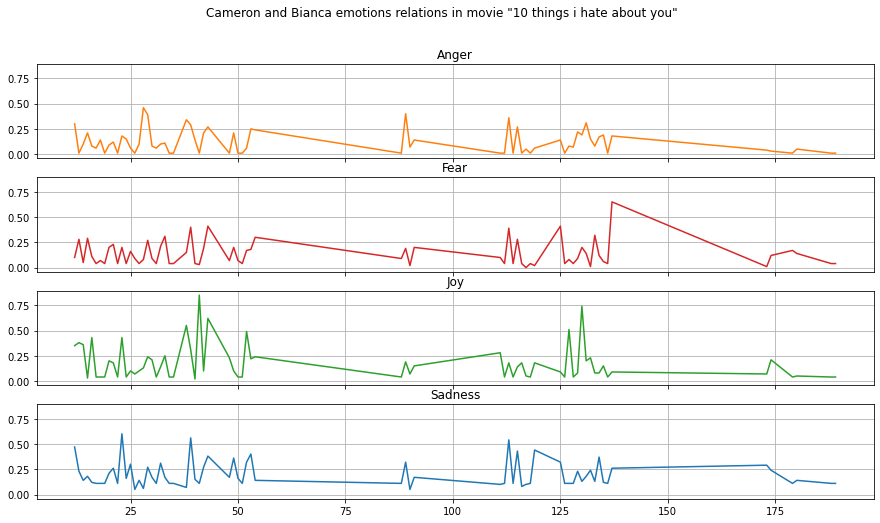

In [88]:
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(15,8))
fig.suptitle('Cameron and Bianca emotions relations in movie "10 things i hate about you"')

mask = (df_plot_1['characterID_1'] == 'u0 ') & (df_plot_1['characterID_2'] == ' u2 ')

axs[0].set_title("Anger")
axs[0].grid()
axs[0].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'anger_proba'],
           'tab:orange')

axs[1].set_title("Fear")
axs[1].grid()
axs[1].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'fear_proba'],
            'tab:red')
    
axs[2].set_title("Joy")
axs[2].grid()
axs[2].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'joy_proba'],
            'tab:green')

axs[3].set_title("Sadness")
axs[3].grid()
axs[3].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'sadness_proba'],
            'tab:blue')


plt.show()

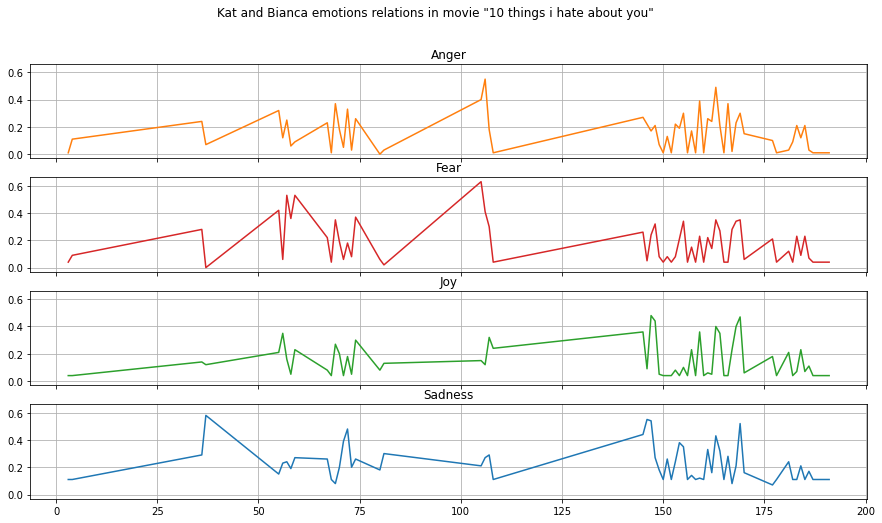

In [89]:
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(15,8))
fig.suptitle('Kat and Bianca emotions relations in movie "10 things i hate about you"')

mask = (df_plot_1['characterID_1'] == 'u0 ') & (df_plot_1['characterID_2'] == ' u5 ')

axs[0].set_title("Anger")
axs[0].grid()
axs[0].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'anger_proba'],
           'tab:orange')

axs[1].set_title("Fear")
axs[1].grid()
axs[1].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'fear_proba'],
            'tab:red')
    
axs[2].set_title("Joy")
axs[2].grid()
axs[2].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'joy_proba'],
            'tab:green')

axs[3].set_title("Sadness")
axs[3].grid()
axs[3].plot(df_plot_1.loc[mask, 'speech_count'],
            df_plot_1.loc[mask, 'sadness_proba'],
            'tab:blue')


plt.show()